# Latent Audio Diffusion - Workflow test 

This notebook tests loading and using the following workflow: 
- Load 20 spectrogram images 
- Encode them into the latent space of a VAE 
- Interpolate between 2 of the encoded images and decode the result
- Pass the decoded image through an image2image diffusion model (Networkbending not yet tested with low strength)
- convert the image back to audio using MelGan 


## Futher development required

I need to try a similar method with just the audio diffusion pipeline to see if I can use that to generate spectrograms -- the idea being that I wont need to use image2image diffusion and can therefore ulise full strength networkbending. However, it seems AudioDiffusion requires many iterations to work, making it unsuitable for realtime purposes, but more experimentation is required.

The proposed method would utilise the AudioDiffusion pipeline: 

- Encode spectrograms again into a VAE 
- Decode an image
- Pass the image through audio diffusion model (image_2_audio) (networkbending can be applied on the unet here)


In [2]:
import torch
import random
import numpy as np
from IPython.display import Audio
from diffusers import DiffusionPipeline, DDIMScheduler, AutoPipelineForImage2Image, AutoencoderKL, AudioDiffusionPipeline
from datasets import load_dataset
from diffusers.utils import load_image

device = "cuda" if torch.cuda.is_available() else "cpu"

mel_pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-256")
mel_pipe.scheduler = DDIMScheduler()
mel_pipe.to(device)
mel = mel_pipe.mel

image_pipe = AutoPipelineForImage2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float32, variant="fp16")
image_pipe.to(device)

generator=torch.Generator(device="cpu").manual_seed(42)

ds = load_dataset('teticio/audio-diffusion-breaks-256')

url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"  # can also be a local file
vae = AutoencoderKL.from_single_file(url)


c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
unet\diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\danhearn\.cache\huggingface\hub\models--teticio--audio-diffusion-256\snapshots\a098cdacf70bcbc28c6f2927824e18792f756f8f\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\danhearn\.cache\huggingface\hub\models--teticio--audio-diffusion-256\snapshots\a098cdacf70bcbc28c6f2927824e18792f756f8f\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


### Load 20 images from the dataset

In [3]:
#load data
images = []

for i in range(20):
    images.append(random.choice(ds['train'])['image'])
    Audio(data=mel.image_to_audio(images[-1]), rate=mel.get_sample_rate())

images

[<PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.Pn

### Encode each image in the Latent space of the VAE

In [4]:
#encode images in latent space
encoded_images = []

for i in images:
    input_image = np.frombuffer(i.tobytes(), dtype="uint8").reshape(
        (i.height, i.width, 1))
    input_image = np.repeat(input_image, 3, axis=2)  # Convert to 3 channels
    input_image = ((input_image / 255) * 2 - 1).transpose(2, 0, 1)
    posterior = vae.encode(torch.tensor([input_image],
                                      dtype=torch.float32)).latent_dist
    encoded_images.append(posterior.sample())

encoded_images

C:\Users\danhearn\AppData\Local\Temp\ipykernel_29728\3111234263.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  posterior = vae.encode(torch.tensor([input_image],


[tensor([[[[ -6.6939,   9.8205,   2.6730,  ...,   4.4571,   4.5306,  -5.4449],
           [ -3.2603,   5.5915,   5.3269,  ...,   6.0882,   3.1291,   0.6183],
           [ -0.9378,   2.1857,   1.9216,  ...,   0.1119,   1.7041,  -3.2093],
           ...,
           [ -5.0641,  -0.3033,   0.6115,  ...,  -2.6778,  -0.6819,   2.9741],
           [ -2.9069,  -0.5565,  -4.2890,  ...,  -8.0142, -13.0744,  -3.5984],
           [-10.0824, -10.3040,  -9.9498,  ..., -11.7174, -10.9377,  -8.6713]],
 
          [[  0.8335,  -1.1085,   0.5941,  ...,  -2.2662,   1.0924,   3.1853],
           [  6.0122,   5.6138,   2.1254,  ...,   5.2541,   3.5437,  -2.5508],
           [  3.9670,  -1.5506,  -1.3654,  ...,  -0.0571,  -1.9662,  -1.0925],
           ...,
           [ -2.7720,   1.0643,   0.8951,  ...,   0.3718,   2.1869,  -3.3247],
           [  2.9432,  -7.4844,   0.0875,  ...,  -2.9314,  -7.6127,  -9.6644],
           [  2.5621,  -1.8259,  -2.0062,  ...,  -7.2562,  -0.1291,  -9.7418]],
 
          [[ -

### Interpolate between two of the encoded images in the VAE and decode the image.

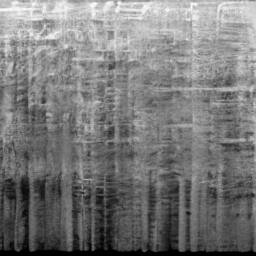

In [5]:
from PIL import Image

# interpolate and decode images

alpha = 0.5 # interpolation factor - 0.0: first image, 1.0: second image

output_image = vae.decode(AudioDiffusionPipeline.slerp(encoded_images[5], encoded_images[19], alpha))['sample']
output_image = torch.clamp(output_image, -1., 1.)
output_image = (output_image + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
output_image = (output_image.detach().cpu().numpy() *
                255).round().astype("uint8").transpose(0, 2, 3, 1)[0, :, :, 0]
output_image = Image.fromarray(output_image)
display(output_image)
Audio(data=mel.image_to_audio(output_image), rate=mel.get_sample_rate())

### Define the image for image2image

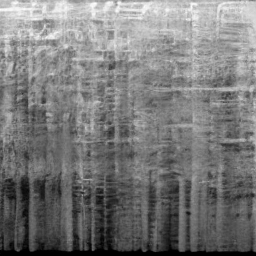

In [6]:

init_image = load_image(output_image)

display(init_image)

### Pass the image through the diffusion model so we can networkbend it

c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
1it [00:02,  2.30s/it]


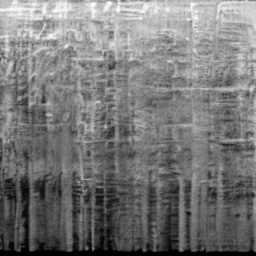

In [7]:
image = image_pipe("spectrogram", image=init_image, num_inference_steps=4, strength=0.2, guidance_scale=11, generator=generator).images[0]

img = image.convert("L")
display(img)

audio = mel.image_to_audio(img)

display(Audio(audio, rate=22050))